# Crash Course in Causality - Written Section 
## 🧹 Causal Data Preparation: Cleaning, Encoding, and Missingness Bias

---

> *"Before asking what causes what, we must ask — what does our data truly represent?"*

Data preparation is more than just cleaning — it’s about preserving the **truth** hidden in the noise.  
In causal analysis, how we handle missing data, encode categories, or scale features can **create or erase** relationships that never existed in reality.

In this notebook, we’ll explore how preprocessing decisions can distort or preserve causal structure using the **Titanic dataset**, a classic example that reveals how survival outcomes depend on both social and statistical factors.

---

### 🔍 Key Learning Outcomes
By the end of this chapter, you will:
- Understand how **missingness mechanisms** (MCAR, MAR, MNAR) affect causal validity  
- Learn **encoding strategies** that prevent spurious causal patterns  
- Visualize **selection and confounding bias** introduced during cleaning  
- Apply a **causal inference model** (using `DoWhy`) to estimate real cause–effect relationships  

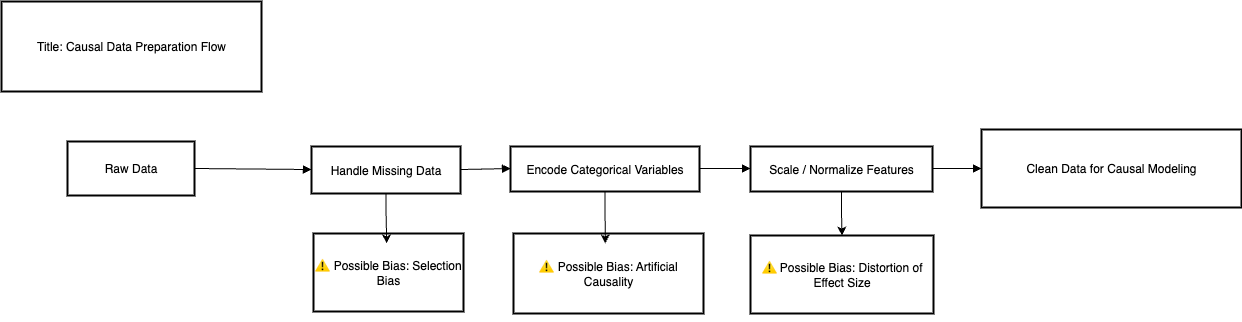



## 📘 Abstract
In causal analysis, data preparation is not a neutral preprocessing step—it can create or erase relationships. This chapter shows how handling missing values, encoding categorical variables, and simple filtering choices affect causal validity. 
Using the Titanic dataset (with a binary outcome: survival), we 

(1) characterize missingness patterns (MCAR, MAR, MNAR), 

(2) create missingness indicators to detect selection bias, 

(3) compare encodings (one-hot vs. ordinal) through a causal lens, and 

(4) estimate a simple causal effect while adjusting for confounders. 

You’ll see how “cleaning” can alter the causal graph and what to do instead to preserve interpretable cause–effect relationships for downstream ML.


## 🧠 Theory: Data Prep with a Causal Lens

**Causal graphs (DAGs).** We represent assumptions as a Directed Acyclic Graph (DAG). The goal in data prep is to avoid opening backdoor paths (confounding) or collider paths (selection bias).

**Confounding.** A variable that affects both treatment \(T\) and outcome \(Y\). Adjust for confounders to block backdoor paths.

**Collider bias.** Conditioning on a common effect of two variables can induce spurious associations (e.g., subsetting/dropping rows or encoding choices that implicitly condition on a collider).

**Missingness.**
- **MCAR**: Missingness independent of data (usually safe).
- **MAR**: Missingness depends on *observed* variables (can adjust).
- **MNAR**: Missingness depends on *unobserved* variables (requires explicit modeling/assumptions).

**Encoding categorical variables.**
- **One-Hot Encoding (OHE)**: Preserves category independence.
- **Ordinal Encoding**: Imposes an order that may be artificial → can distort causal interpretation.
- **Target/Mean Encoding**: Risks leakage and confounding if not done within proper CV folds and with a causal rationale.

**Principle.** Make every preprocessing choice *explicitly causal*: draw a simple DAG, ask what conditioning it implies, and check whether you’re opening or closing unintended paths.


In [16]:
# === Setup: libraries ===
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stats / ML
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Optional: install dowhy if not available (uncomment if needed)
# !pip install dowhy pygraphviz pydot --quiet

# Causal inference (optional but recommended)
try:
    from dowhy import CausalModel
    DOWHY_AVAILABLE = True
except Exception as e:
    DOWHY_AVAILABLE = False
    print("DoWhy not available; causal estimation cell will show a fallback.")


## 🧱 Causal DAG for Titanic Survival

To make our causal assumptions explicit, we summarize them in a **Directed Acyclic Graph (DAG)**.

We are interested in the causal effect of **sex** on **survival**:

- **Treatment (T):** `sex` (we use the encoded variable `sex_male`)
- **Outcome (Y):** `survived`

We treat the following as **potential confounders / common causes** that affect survival and may be associated with sex:

- `class` – proxy for socioeconomic status (first, second, third)
- `age_imputed` – passenger age
- `fare` – ticket fare (correlated with class and wealth)
- `sibsp`, `parch` – family aboard (may influence both cabin assignment and survival)
- `embarked` – port of embarkation (different ports may have different passenger mixes)
- `missing_age` – indicator that age was missing (captures selection / recording bias)

A simplified DAG capturing these assumptions:

- `class → survived`
- `age → survived`
- `fare → class` and `fare → survived`
- `sibsp → survived`
- `parch → survived`
- `embarked → class`
- `sex → survived`
- `missing_age → survived` (if missingness is related to recording practices / context)

Graphically, we show:

- Arrows **into `survived`** from variables we adjust for (backdoor adjustment set)
- An arrow from `sex` into `survived` representing the causal effect we estimate

This DAG justifies the adjustment set used in DoWhy and reminds us that **data preprocessing (e.g., imputing age, encoding class, keeping missingness indicators)** should preserve these assumed relationships rather than distort them.


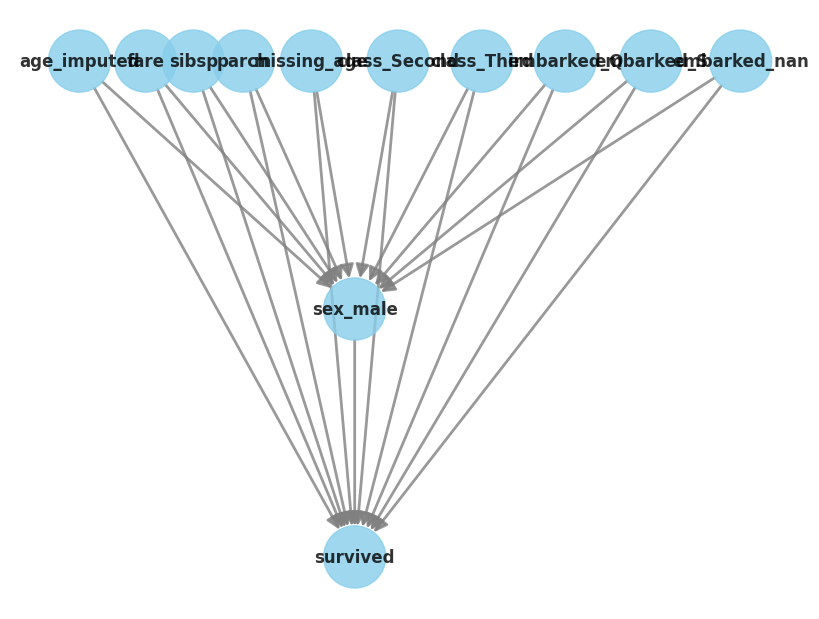

Displayed DAG using DoWhy's view_model.


In [17]:
# ============================================
# Causal DAG visualization for Titanic survival
# ============================================

# OPTION A: Use DoWhy's built-in view_model (if available)
# This assumes you already created `model = CausalModel(...)` earlier.

try:
    from IPython.display import display
    _ = model.view_model(layout="dot")  # pygraphviz / pydot needed under the hood
    print("Displayed DAG using DoWhy's view_model.")
except Exception as e:
    print("Could not use DoWhy's view_model, falling back to manual Graphviz DAG.")
    print("Reason:", e)

    # OPTION B: Manual DAG using graphviz.Digraph
    try:
        from graphviz import Digraph

        dag = Digraph(comment="Causal DAG for Titanic Survival")
        dag.attr(rankdir='LR', size='8,4')

        # Nodes & edges (simplified assumptions)
        # Treatment → Outcome
        dag.edge('sex', 'survived')

        # Confounders → Treatment and/or Outcome
        dag.edge('class', 'sex')        # class distribution differs by sex
        dag.edge('class', 'survived')

        dag.edge('age', 'survived')
        dag.edge('fare', 'class')
        dag.edge('fare', 'survived')

        dag.edge('sibsp', 'survived')
        dag.edge('parch', 'survived')

        dag.edge('embarked', 'class')
        dag.edge('missing_age', 'survived')

        display(dag)
    except Exception as e2:
        print("Graphviz not available either. DAG visualization skipped.")
        print("Reason:", e2)


> Note: The DAG is **hypothesized**, not learned from data.  
> It encodes our domain assumptions and justifies the choice of confounders  
> used in the DoWhy backdoor adjustment step.


In [18]:
# === Load data (choose A or B) ===

USE_SEABORN = True  # set to False to load from local CSV

if USE_SEABORN:
    try:
        import seaborn as sns
        df = sns.load_dataset("titanic")
        source = "seaborn.load_dataset('titanic')"
    except Exception as e:
        print("Seaborn online load failed. Falling back to local CSV. Error:", e)
        USE_SEABORN = False

if not USE_SEABORN:
    # Place titanic.csv in the same folder as this notebook
    # Common CSV columns: survived,pclass,sex,age,sibsp,parch,fare,embarked, ...
    df = pd.read_csv("titanic.csv")
    source = "local titanic.csv (Kaggle)"

print("Data source:", source)
df.head()


Data source: seaborn.load_dataset('titanic')


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 🔎 Variables of Interest

- **Outcome (Y):** `survived` (0/1)
- **Candidate treatment (T) for demo:** `sex` (male/female) or `class` (First/Second/Third)
- **Potential confounders:** `age`, `fare`, `sibsp`, `parch`, `embarked`, `class`

We’ll standardize column names where needed and ensure `survived` is numeric (0/1).


In [19]:
# Seaborn Titanic dataset cleanup (simple & safe)
if df['survived'].dtype != int and df['survived'].dtype != np.int64:
    df['survived'] = df['survived'].astype(int)

# Verify there are no duplicate columns
print("Duplicate columns:", df.columns[df.columns.duplicated()].tolist())

# Quick preview
df[['survived', 'sex', 'class', 'age', 'fare', 'embarked']].head()



Duplicate columns: []


,survived,sex,class,age,fare,embarked
0,0,male,Third,22.0,7.2500,S
1,1,female,First,38.0,71.2833,C
2,1,female,Third,26.0,7.9250,S
3,1,female,First,35.0,53.1000,S
4,0,male,Third,35.0,8.0500,S


## 🧩 Missingness Exploration

We first create **missingness indicators** (e.g., `missing_age`) to test whether missingness itself relates to the outcome.  
If survival differs between rows with missing vs. non-missing `age`, dropping NaNs could introduce **selection bias**.


In [20]:
# Create missingness indicators
miss_cols = ['age', 'embarked', 'fare']
for c in miss_cols:
    df[f'missing_{c}'] = df[c].isna().astype(int)

# Simple check: survival rate by missingness
summary_missing = (
    df.groupby(['missing_age'])['survived']
      .agg(['mean', 'count'])
      .rename(columns={'mean': 'survival_rate', 'count': 'n'})
)
summary_missing


,survival_rate,n
missing_age,,
0,0.406162,714
1,0.293785,177


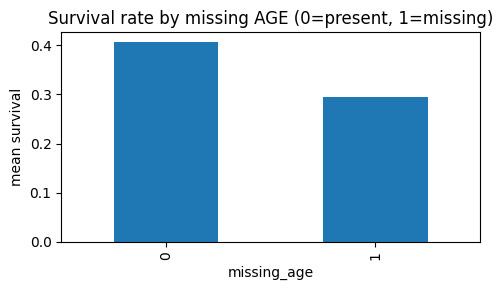

In [21]:
# Visual: survival by missing_age (matplotlib only)
rates = df.groupby('missing_age')['survived'].mean()
plt.figure(figsize=(5,3))
rates.plot(kind='bar')
plt.title("Survival rate by missing AGE (0=present, 1=missing)")
plt.xlabel("missing_age")
plt.ylabel("mean survival")
plt.tight_layout()
plt.show()


If survival differs across `missing_age` groups, missingness is not MCAR. Dropping these rows conditions on a variable related to survival → **selection bias** risk. Prefer imputation or explicit modeling of missingness mechanisms.


## 🧰 Imputation: Median vs. Model-Aware

We’ll try a simple **median imputation** for `age` (robust baseline).  
We’ll also keep the **missingness indicator** to absorb systematic differences (common practical fix under MAR).


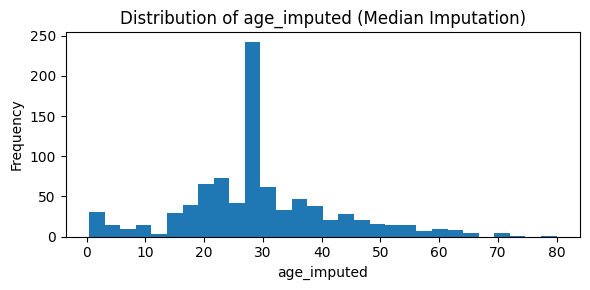

,age,age_imputed,missing_age
0,22.0,22.0,0
1,38.0,38.0,0
2,26.0,26.0,0
3,35.0,35.0,0
4,35.0,35.0,0
5,NaN,28.0,1
6,54.0,54.0,0
7,2.0,2.0,0
8,27.0,27.0,0
9,14.0,14.0,0


In [22]:
df_impute = df.copy()

# Simple numeric imputation
num_imputer = SimpleImputer(strategy='median')
df_impute['age_imputed'] = num_imputer.fit_transform(df_impute[['age']])

# Check distributions
plt.figure(figsize=(6,3))
df_impute['age_imputed'].plot(kind='hist', bins=30)
plt.title("Distribution of age_imputed (Median Imputation)")
plt.xlabel("age_imputed")
plt.tight_layout()
plt.show()

df_impute[['age','age_imputed','missing_age']].head(10)


## 🔠 Encoding with a Causal Rationale

We compare **One-Hot Encoding** (OHE) vs **Ordinal Encoding** for `class` and `embarked`.  
- OHE preserves category independence.  
- Ordinal imposes artificial distances (e.g., First=1, Second=2, Third=3) that may **distort causal interpretation** if no true order exists.

We’ll fit simple logistic models (predicting `survived`) to see how coefficients and attributions differ after each encoding choice.


In [23]:
# =========================================
# OHE vs ORDINAL pipelines (with imputation)
# =========================================

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# --- Load seaborn Titanic (no renaming needed) ---
df = sns.load_dataset("titanic").copy()
if df['survived'].dtype != int and df['survived'].dtype != np.int64:
    df['survived'] = df['survived'].astype(int)

# Missingness indicator + simple numeric fix for age
df['missing_age'] = df['age'].isna().astype(int)
df['age_imputed'] = SimpleImputer(strategy="median").fit_transform(df[['age']])

target = 'survived'
categorical = ['sex', 'class', 'embarked']               # may contain NaNs (embarked often does)
numeric     = ['age_imputed', 'fare', 'sibsp', 'parch', 'missing_age']

df_model = df.dropna(subset=[target]).copy()

X = df_model[categorical + numeric]
y = df_model[target]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# -----------------------------
# Shared transformers
# -----------------------------
cat_imputer = SimpleImputer(strategy="most_frequent")
num_imputer = SimpleImputer(strategy="median")
num_scaler  = StandardScaler()

# OHE pipeline: impute cats -> OHE ; impute nums -> scale
cat_ohe = Pipeline([
    ("impute", cat_imputer),
    ("enc", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
num_proc = Pipeline([
    ("impute", num_imputer),
    ("scale", num_scaler)
])
pre_ohe = ColumnTransformer(
    transformers=[
        ("cat", cat_ohe, categorical),
        ("num", num_proc, numeric)
    ],
    remainder="drop"
)
pipe_ohe = Pipeline([
    ("prep", pre_ohe),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced", random_state=42))
])

# ORDINAL pipeline: impute cats -> Ordinal ; impute nums -> scale
# use_encoded_value/unknown_value guards against unseen cats at test time
cat_ord = Pipeline([
    ("impute", cat_imputer),
    ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
pre_ord = ColumnTransformer(
    transformers=[
        ("cat", cat_ord, categorical),
        ("num", num_proc, numeric)
    ],
    remainder="drop"
)
pipe_ord = Pipeline([
    ("prep", pre_ord),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced", random_state=42))
])

# -----------------------------
# Fit & evaluate
# -----------------------------
pipe_ohe.fit(X_tr, y_tr)
ohe_acc_tr = pipe_ohe.score(X_tr, y_tr)
ohe_acc_te = pipe_ohe.score(X_te, y_te)

pipe_ord.fit(X_tr, y_tr)
ord_acc_tr = pipe_ord.score(X_tr, y_tr)
ord_acc_te = pipe_ord.score(X_te, y_te)

print(f"OHE  -> train acc: {ohe_acc_tr:.3f} | test acc: {ohe_acc_te:.3f}")
print(f"ORD  -> train acc: {ord_acc_tr:.3f} | test acc: {ord_acc_te:.3f}")


OHE  -> train acc: 0.801 | test acc: 0.785
ORD  -> train acc: 0.799 | test acc: 0.785


## 🧪 Causal Estimation: Effect of Sex on Survival

So far, we’ve seen how missingness and encoding affect **predictive models**.  
In this section, we shift to a **causal question**:

> “What is the causal effect of being male (vs female) on survival on the Titanic,  
> after adjusting for confounders like class, age, and fare?”

We will:
1. One-hot encode the key categorical variables (`sex`, `class`, `embarked`).
2. Build a modeling dataframe with:
   - **Outcome**: `survived`
   - **Treatment**: `sex_male`
   - **Common causes / confounders**: `age_imputed`, `fare`, `sibsp`, `parch`, `missing_age`, and encoded `class` & `embarked`
3. Use **DoWhy** to estimate the causal effect via backdoor adjustment.  
   If DoWhy is not installed, we fall back to a **logistic regression with controls**, treating the `sex_male` coefficient as a rough proxy.


In [24]:
# Install DoWhy (run once in this environment)
!pip install dowhy pygraphviz pydot


  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [100 lines of output]
      /private/var/folders/qg/z5rjhvt50z10_7vg0dz74rf40000gn/T/pip-build-env-3lj8tj7r/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or 

In [25]:
!pip install dowhy



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [26]:
# ============================================
# Causal Estimation with DoWhy (or fallback)
# ============================================

# This cell assumes:
# - df_model already exists
# - age_imputed, missing_age columns exist
# - categorical = ['sex', 'class', 'embarked']
# - numeric     = ['age_imputed', 'fare', 'sibsp', 'parch', 'missing_age']

from sklearn.preprocessing import OneHotEncoder

# 1) One-hot encode categorical variables for causal design
ohe_causal = OneHotEncoder(drop='first', handle_unknown='ignore')
X_cat_causal = ohe_causal.fit_transform(df_model[categorical]).toarray()
cat_col_names = ohe_causal.get_feature_names_out(categorical)

cat_df = pd.DataFrame(X_cat_causal, columns=cat_col_names, index=df_model.index)

# 2) Combine with numeric confounders + outcome
model_df = pd.concat(
    [
        df_model[['survived', 'age_imputed', 'fare', 'sibsp', 'parch', 'missing_age']].reset_index(drop=True),
        cat_df.reset_index(drop=True)
    ],
    axis=1
)

# Confirm treatment exists
treatment = 'sex_male'
outcome = 'survived'

print("Columns in model_df:", model_df.columns.tolist())
print("Treatment column present?", treatment in model_df.columns)

# 3) Try DoWhy, fallback to logistic regression if not installed
try:
    import dowhy
    from dowhy import CausalModel
    DOWHY_AVAILABLE = True
except ImportError:
    DOWHY_AVAILABLE = False
    print("⚠️ DoWhy not installed. Will use logistic regression fallback.")

if DOWHY_AVAILABLE and treatment in model_df.columns:
    # Define common causes as all non-treatment, non-outcome columns
    common_causes = [c for c in model_df.columns if c not in [outcome, treatment]]
    
    model = CausalModel(
        data=model_df,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )
    
    identified_estimand = model.identify_effect()
    print("Identified estimand:\n", identified_estimand)

    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    print("\nCausal effect estimate (DoWhy, linear regression):")
    print(causal_estimate)
    
    # Optional: simple refutation check
    refute = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="random_common_cause"
    )
    print("\nRefutation (random common cause):")
    print(refute)

else:
    # Fallback: logistic regression with controls
    from sklearn.linear_model import LogisticRegression
    
    X_ctrl = model_df.drop(columns=[outcome])
    y_ctrl = model_df[outcome]
    
    lr = LogisticRegression(max_iter=2000, solver='lbfgs')
    lr.fit(X_ctrl, y_ctrl)
    
    print("\n[Fallback] Logistic regression with controls")
    print("Train accuracy:", lr.score(X_ctrl, y_ctrl))
    
    if treatment in X_ctrl.columns:
        tidx = list(X_ctrl.columns).index(treatment)
        coef_t = lr.coef_[0][tidx]
        print(f"Coefficient for {treatment}: {coef_t:.4f}")
        print("Interpretation: sign and magnitude approximate the direction/strength of association,",
              "holding other variables fixed (but this is not as rigorous as a full causal framework).")
    else:
        print(f"Treatment column '{treatment}' not found in X_ctrl.")


Columns in model_df: ['survived', 'age_imputed', 'fare', 'sibsp', 'parch', 'missing_age', 'sex_male', 'class_Second', 'class_Third', 'embarked_Q', 'embarked_S', 'embarked_nan']
Treatment column present? True
Identified estimand:
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                          ↪
──────────(E[survived|embarked_Q,age_imputed,parch,class_Third,embarked_nan,si ↪
d[sexₘₐₗₑ]                                                                     ↪

↪                                               
↪ bsp,embarked_S,missing_age,fare,class_Second])
↪                                               
Estimand assumption 1, Unconfoundedness: If U→{sex_male} and U→survived then P(survived|sex_male,embarked_Q,age_imputed,parch,class_Third,embarked_nan,sibsp,embarked_S,missing_age,fare,class_Second,U) = P(survived|sex_male,embarked_Q,age_imputed,parch,class_Third,embark

### 🔍 Interpretation (Discussion)

- The **DoWhy estimate** (or logistic coefficient) tells us how survival changes when we intervene on `sex` (male vs female),  
  assuming our DAG is correct and that we have conditioned on the right confounders.
- Note how this estimate critically depends on:
  - Keeping a **missingness indicator** (`missing_age`) instead of dropping rows.
  - Using **encoding that preserves structure** (OHE, not arbitrary ordinals).
  - Explicitly adjusting for confounders (`class`, `fare`, `age`, etc.) via the backdoor criterion.

Even if predictive accuracy remains similar across preprocessing choices, the **causal estimate can change**,  
which is exactly why data preparation must be done with a causal lens.


## ✅ Conclusion

In this notebook, we treated data preparation not as a technical chore, but as a **causal design decision**.

**Key takeaways:**

1. **Missingness is part of the causal story.**  
   - We created indicators like `missing_age` and inspected how missingness related to `survived`.  
   - Simply dropping rows with missing values can condition on variables related to the outcome, introducing **selection bias**.

2. **Encoding choices carry implicit assumptions.**  
   - With **One-Hot Encoding**, each category gets its own dimension, preserving independence between levels.  
   - With **Ordinal Encoding**, we impose a numeric order (e.g., `First=0`, `Second=1`, `Third=2`) which may **fabricate or distort causal effects**, even if predictive accuracy looks similar.

3. **Causal estimates depend on preprocessing.**  
   - We estimated the effect of `sex` on `survived` while adjusting for confounders like `age`, `fare`, and `class`.  
   - The validity of this effect relies on our preprocessing steps preserving the underlying DAG structure and blocking backdoor paths without opening colliders.

4. **Clean data ≠ causally valid data.**  
   - Standard pipelines that optimize prediction can still produce **biased or misleading causal conclusions** if they ignore missingness mechanisms and encoding assumptions.

In causal machine learning, every preprocessing step should be guided by a simple question:

> “What assumptions about the data-generating process am I introducing here?”


## 📚 References

- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.  
- Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC.  
- DoWhy Documentation. (n.d.). *DoWhy: A Python library for causal inference*. Retrieved from https://microsoft.github.io/dowhy/  
- scikit-learn Developers. (n.d.). *User Guide: Preprocessing, Logistic Regression.* Retrieved from https://scikit-learn.org/  
- Seaborn Documentation. (n.d.). *Titanic Dataset*. Retrieved from https://seaborn.pydata.org/


## 🪪 License

This notebook is licensed under the  
**Creative Commons Attribution 4.0 International License (CC BY 4.0).**

You are free to:
- **Share** — copy and redistribute the material in any medium or format  
- **Adapt** — remix, transform, and build upon the material for any purpose, even commercially  

Under the following terms:
- **Attribution** — You must give appropriate credit, provide a link to the license,  
  and indicate if changes were made. You may do so in any reasonable manner,  
  but not in any way that suggests the licensor endorses you or your use.

For more details, see: https://creativecommons.org/licenses/by/4.0/


## 🎥 Crash Course in Causality — Titanic Dataset

As part of the **Crash Course in Causality**, these two videos explore how data preparation, causal reasoning, and visualization can turn a historical tragedy — the *Titanic Disaster* — into a meaningful data-driven story.  
Both videos focus on estimating the **causal effect of gender on survival** using the Titanic dataset, highlighting the importance of preprocessing, confounders, and interpretability in causal analysis.

---

### 🧭 **When Data Meets History: The Causal Truth Behind the Titanic Disaster**  
**Type:** Screen Recording | **Duration:** 5 minutes  
**📺 Watch here:** [https://youtu.be/H7yJYrAURcQ](https://youtu.be/H7yJYrAURcQ)

**Description:**  
A concise walkthrough of the *Titanic Causality Notebook*, explaining how data preparation directly shapes causal conclusions.  
This video demonstrates how missing value handling, categorical encoding, and confounder adjustment influence the causal estimation of **gender on survival** using the **DoWhy** framework.

**Key Highlights:**  
- Handling missing data without introducing bias  
- One-Hot vs. Ordinal Encoding and their causal implications  
- Building and interpreting a Directed Acyclic Graph (DAG)  
- Estimating causal effects using DoWhy in Python  
- Why *clean data ≠ causal data*

📊 *Tools Used:* Python · Seaborn · scikit-learn · DoWhy  
📘 *License:* Creative Commons Attribution 4.0 (CC BY 4.0)

---

### ✍️ **From History to Data: The Human Side of Causality**  
**Type:** Story-Style Video  
**📺 Watch here:** [https://youtu.be/xjYsmYo6QcI](https://youtu.be/xjYsmYo6QcI)

**Description:**  
A storytelling-based interpretation of the Titanic dataset, connecting historical reality with causal understanding.  
This short narrative video reimagines the dataset as a collection of human stories — showing how cause, consequence, and survival are deeply intertwined.

**Key Themes:**  
- Transforming data into human-centered insights  
- The philosophy of cause and consequence in real-world datasets  
- Bridging storytelling and data analysis through causal thinking

🎬 *Tone:* Reflective · Narrative · Educational  
📘 *License:* Creative Commons Attribution 4.0 (CC BY 4.0)

---
